<a href="https://colab.research.google.com/github/ten2net/ppo/blob/main/Day20%EF%BC%9A%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92%E5%9C%A8%E4%BA%A4%E6%98%93%E4%B8%AD%E7%9A%84%E6%87%89%E7%94%A8_%E4%BD%BF%E7%94%A8_Stable_Baselines_3_%E5%AF%A6%E7%8F%BE%E5%9F%BA%E6%96%BC_LSTM_%E7%9A%84%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92%EF%BC%8C%E4%B8%A6%E4%BD%BF%E7%94%A8_Backtrader_%E9%80%B2%E8%A1%8C%E5%9B%9E%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在上次的教學中我們使用了 `Stable baseline3`來搭建我們的 RL agent 並將買賣過程放回 backtrader 上進行視覺化。在本教學中，我們將進一步深入強化學習在金融交易中的應用。我們將使用 Stable Baselines 3 實現一個基於 LSTM（長短期記憶網絡）的強化學習代理，並使用 Backtrader 進行回測。我們的代理將在每個時間步觀察過去 15 天的市場數據，以做出更明智的交易決策。[今日 Colab](https://colab.research.google.com/drive/19PpIVOGlSwR10feAuvINQ9x3-5WSTQjl?usp=sharing)

---

### **一、引言**

#### **1. 為什麼使用 LSTM？**

- **時間序列特性**：股票價格具有時間相關性，過去的價格信息對未來的價格有影響。
- **LSTM 的優勢**：LSTM 能夠捕捉長期和短期的時間依賴性，適合處理時間序列數據。
- **改進決策能力**：通過觀察過去 15 天的數據，代理可以學習市場的趨勢和模式，從而提升交易策略的效果。
![https://ithelp.ithome.com.tw/upload/images/20241005/201205495RQwsaCiO2.png](https://ithelp.ithome.com.tw/upload/images/20241005/201205495RQwsaCiO2.png)
---

### **二、環境設置**

#### **1. 安裝必要的庫**

在 Google Colab 中，我們需要安裝以下庫：

In [1]:
!pip install stable-baselines3
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install backtrader
!pip install yfinance
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

#### **2. 導入庫**


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn

### **三、數據準備**

#### **1. 獲取股票數據**

我們將使用 `yfinance` 下載蘋果公司（AAPL）的歷史數據。

In [46]:
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01', multi_level_index=False)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])  # 確保 Date 列為 datetime 類型
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


#### **2. 數據預處理**


In [47]:
data['Open'] = data['Open'].astype('float32')
data['High'] = data['High'].astype('float32')
data['Low'] = data['Low'].astype('float32')
data['Close'] = data['Close'].astype('float32')
data['Volume'] = data['Volume'].astype('float32')

### **四、定義交易環境**

在這一部分，我們將修改交易環境，使代理在每個時間步能夠觀察過去 15 天的數據。

#### **1. 環境的結構**

- **觀測空間（Observation Space）**：包含過去 15 天的市場數據，每天有 5 個特徵（開、高、低、收、量），因此觀測值的形狀為 `(15, 5)`。
- **行動空間（Action Space）**：代理可以採取的行動，包括買入、賣出和持有。
- **環境狀態**：追蹤代理的持倉、現金餘額和資產淨值。
- **獎勵函數**：根據代理的資產淨值變化計算獎勵，鼓勵代理增加資產淨值。

#### **2. 環境的實作**

In [48]:
class TradingEnv(gym.Env):
    """自訂的交易環境，用於強化學習模型訓練，代理觀察過去 15 天的數據"""

    def __init__(self, data, window_size=10, cash=10000, commission=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index()
        self.cash = cash  # 初始現金
        self.initial_cash = cash  # 紀錄初始現金
        self.commission = commission  # 交易手續費
        self.window_size = window_size  # 觀察窗口大小
        self.current_step = self.window_size  # 開始位置

        # 定義觀測空間和行動空間
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window_size, 5), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 買入, 2: 賣出

        # 初始化帳戶資訊
        self.position = 0  # 持有的股票數量
        self.net_worth = self.cash  # 資產淨值
        self.prev_net_worth = self.cash  # 前一步的資產淨值

        # 紀錄交易訊號
        self.trades = []

    def _get_obs(self):
        """獲取當前的觀測值"""
        obs = self.data.loc[self.current_step - self.window_size:self.current_step - 1, ['Open', 'High', 'Low', 'Close', 'Volume']].values
        return obs

    def reset(self, *, seed=None, options=None):
        """重置環境到初始狀態"""
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.position = 0
        self.cash = self.initial_cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.trades = []  # 重置交易紀錄
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """執行一個行動，並返回新的狀態和獎勵"""
        current_price = self.data.loc[self.current_step, 'Close']

        # 記錄交易訊號
        date = self.data.loc[self.current_step, 'Date']
        self.trades.append({'Date': date, 'Action': action})

        # 計算交易手續費
        commission = 0

        if action == 1:  # 買入
            # 計算可買入的最大股數
            max_shares = int(self.cash / (current_price * (1 + self.commission)))
            if max_shares > 0:
                # 更新帳戶餘額和持倉
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost
                self.position += max_shares
                commission = cost * self.commission
        elif action == 2:  # 賣出
            if self.position > 0:
                # 更新帳戶餘額和持倉
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue
                commission = self.position * current_price * self.commission
                self.position = 0
        # action == 0 表示持有，不執行任何操作

        self.current_step += 1

        # 更新資產淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勵
        reward = self.net_worth - self.prev_net_worth - commission
        self.prev_net_worth = self.net_worth

        # 判斷是否終止
        if self.current_step >= len(self.data):
            terminated = True
        else:
            terminated = False
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        """渲染環境（此處未實作）"""
        pass

#### **3. 實作內容說明**

- **`window_size`**：新增一個參數，指定觀察窗口的大小，這裡設定為 15。
- **`observation_space`**：觀測空間的形狀變為 `(window_size, 5)`。
- **`_get_obs` 方法**：
  - 返回過去 15 天的市場數據作為觀測值。
- **`current_step`**：
  - 初始化為 `window_size`，以確保有足夠的歷史數據。
- **`reset` 和 `step` 方法**：
  - 相應地調整 `current_step`，確保索引不超出數據範圍。

### **五、定義自訂的特徵提取器**

為了使模型能夠處理我們的高維度觀測值（`(15, 5)`），我們需要自訂一個特徵提取器，使用 LSTM 處理時間序列數據。


In [49]:
class CustomLSTMFeatureExtractor(BaseFeaturesExtractor):
    """
    自訂的特徵提取器，使用 LSTM 處理時間序列數據
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 128):
        super(CustomLSTMFeatureExtractor, self).__init__(observation_space, features_dim)
        self.lstm = nn.LSTM(input_size=5, hidden_size=features_dim, batch_first=True)

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # observations shape: (batch_size, window_size, 5)
        lstm_output, (h_n, c_n) = self.lstm(observations)
        # 我們取最後一個時間步的輸出作為特徵
        return h_n[-1]

- **說明**：
  - 我們使用 `nn.LSTM` 處理觀測值。
  - 將輸出的隱藏狀態作為特徵，用於後續的策略網絡。

---

### **六、訓練強化學習模型**

#### **1. 創建環境實例**

In [50]:
env = TradingEnv(data)


#### **2. 檢查環境**


In [51]:
env_checker.check_env(env)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


#### **3. 包裝環境**


In [52]:
env = DummyVecEnv([lambda: env])


#### **4. 定義政策網絡**

我們需要定義一個自訂的政策網絡，使用我們的特徵提取器。

In [53]:
policy_kwargs = dict(
    features_extractor_class=CustomLSTMFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

#### **5. 訓練模型**


In [54]:
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 437  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 367         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006041045 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 4.88e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00108    |
|    value_loss           | 1.32e+05    |
-----------------------------------------
----------------

### **七、測試模型並收集交易訊號**

In [55]:
env.envs[0].reset()
for i in range(env.envs[0].window_size, len(data)):
    obs = env.envs[0]._get_obs()
    # 需要將觀測值轉換為 tensor 並添加 batch 維度
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, truncated, info = env.envs[0].step(action)
    if dones:
        break

- **說明**：
  - 在測試階段，我們使用 `deterministic=True`，以獲取策略的確定性行動。
  - 我們需要確保觀測值的格式正確，與訓練時一致。

### **八、在 Backtrader 上顯示買賣點**
​
#### **1. 獲取交易紀錄並合併數據**

In [56]:
# 從環境中獲取交易紀錄
trades = pd.DataFrame(env.envs[0].trades)

# 將交易紀錄與原始數據合併
data.reset_index(inplace=True)
merged_data = pd.merge(data, trades, on='Date', how='left')
merged_data['Action'].fillna(0, inplace=True)

# 確保 Date 列為 datetime 類型
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

<ipython-input-56-d41afca6bfd7>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Action'].fillna(0, inplace=True)


#### **2. 定義 Backtrader 策略**


In [57]:
class RLStrategy(bt.Strategy):
    """自訂的策略，用於在圖表上顯示買賣點"""

    def __init__(self):
        self.dataclose = self.datas[0].close

    def next(self):
        # 根據交易紀錄執行買賣
        idx = len(self) - 1  # 當前索引
        action = merged_data.loc[idx, 'Action']
        if action == 1 and self.position.size == 0:
            # 買入
            self.buy(size=100)
            print(action,)
        elif action == 2 and self.position.size > 0:
            # 賣出
            self.sell(size=self.position.size)
            print(action,)

#### **3. 設置 Backtrader 並進行回測**


In [58]:
cerebro = bt.Cerebro()
# 在添加數據時，指定 datetime 列
data_bt = bt.feeds.PandasData(
    dataname=merged_data,
    datetime='Date',
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data_bt)
cerebro.addstrategy(RLStrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)

print('初始資金: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('最終資金: %.2f' % cerebro.broker.getvalue())

初始資金: 10000.00
最終資金: 10000.00


#### **4. 繪製圖表**


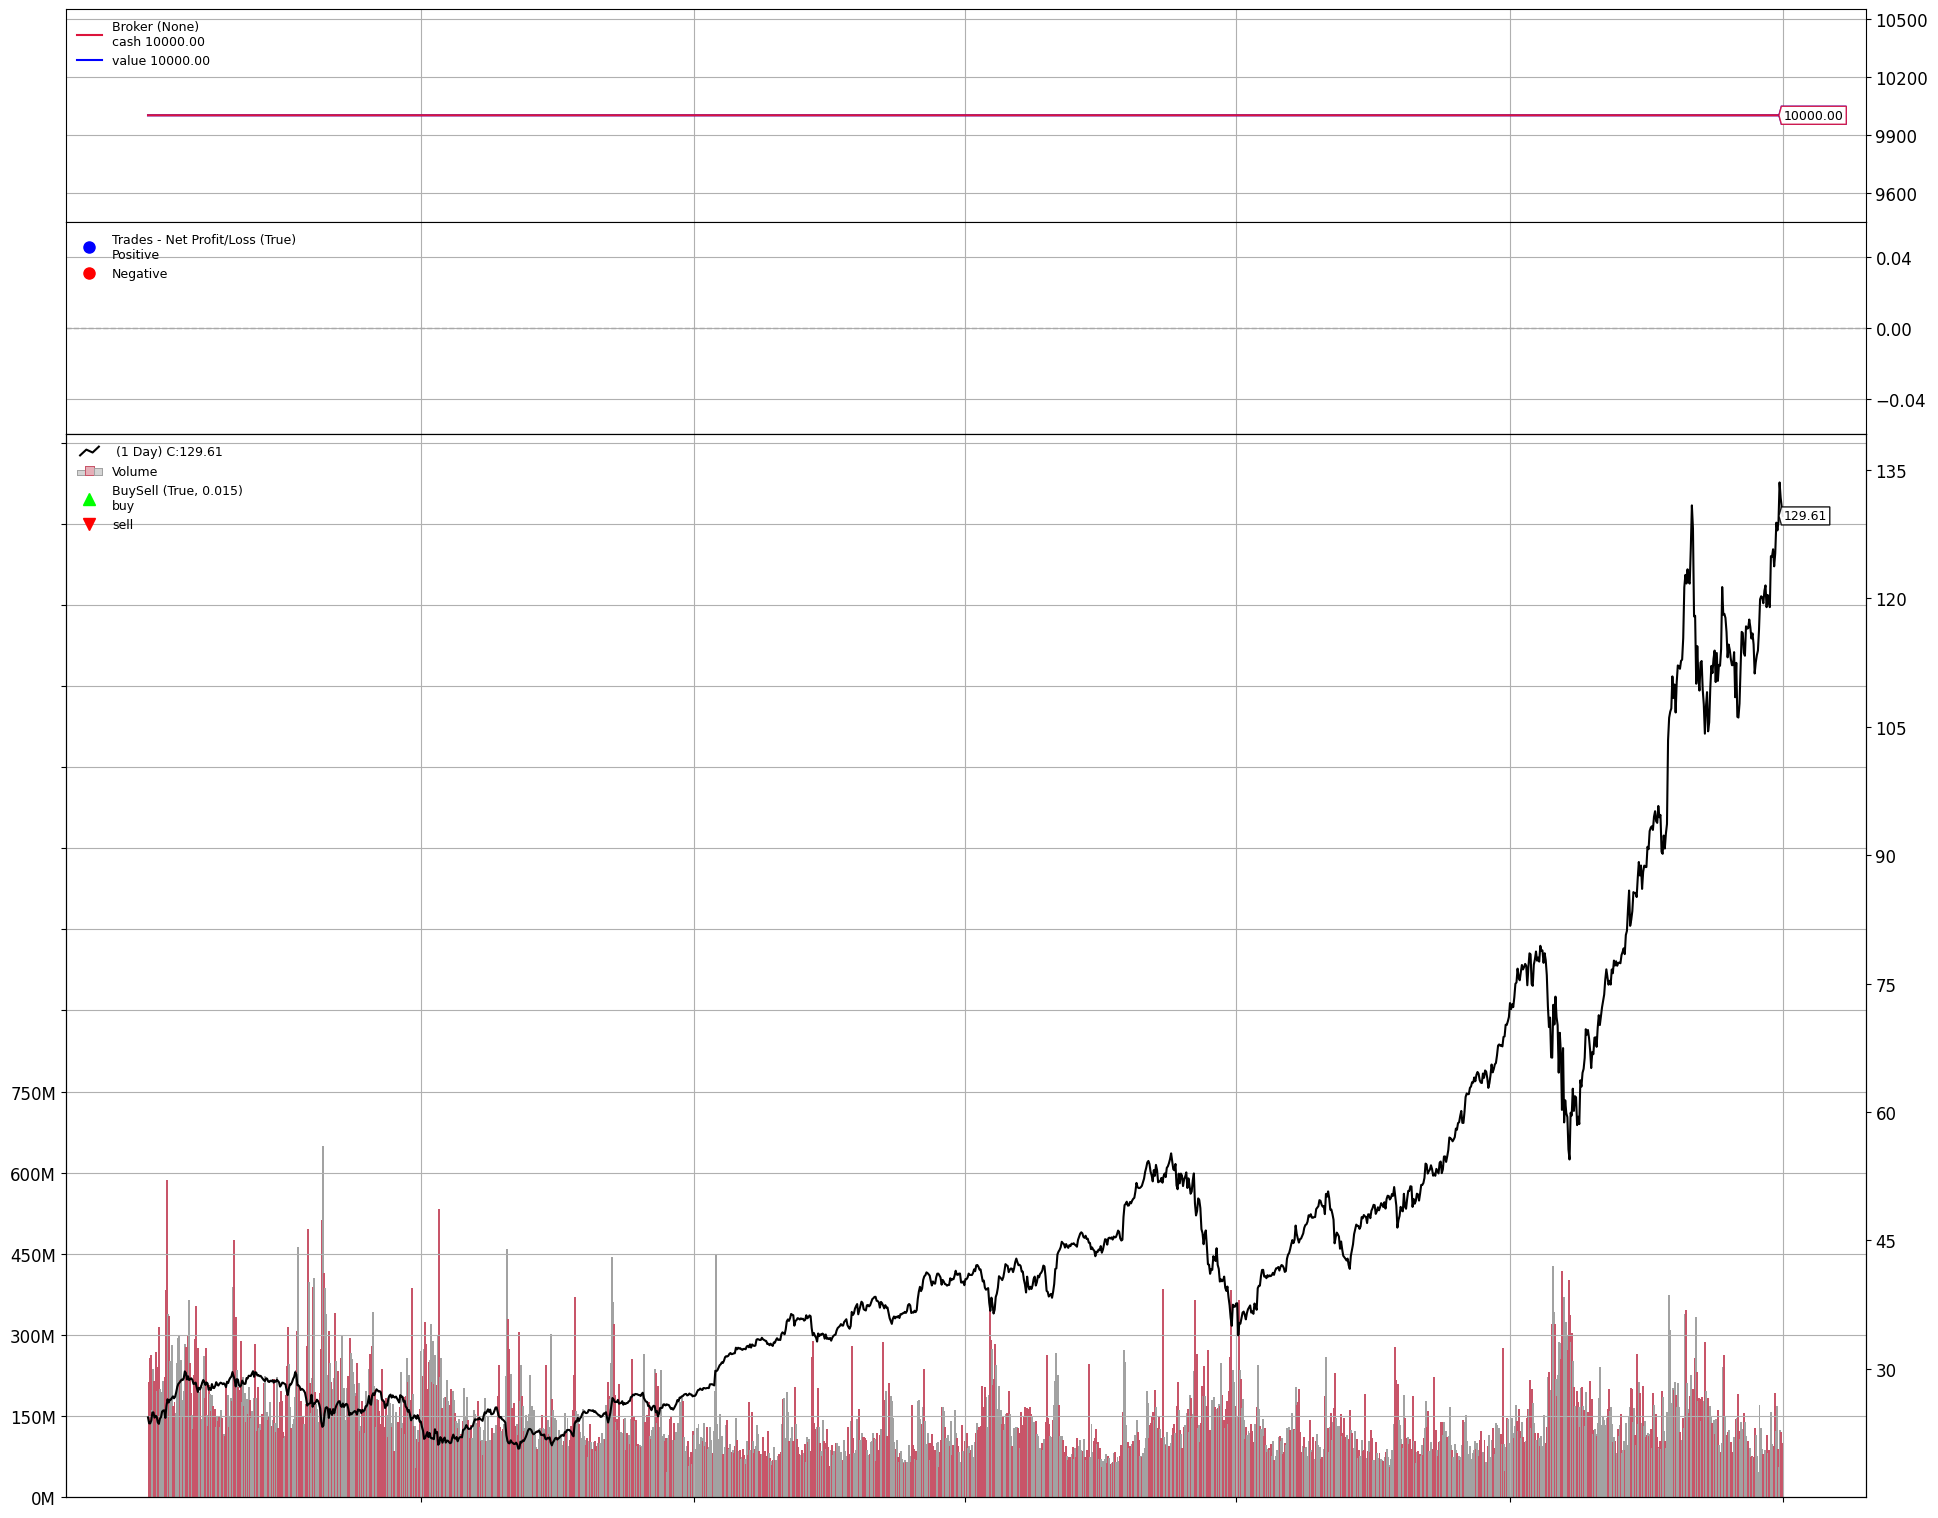

In [59]:
# 繪製圖表
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)
img[0][0].savefig('backtrader_ppo_lstm.png')

### **九、結果分析**

通過 Backtrader 的圖表，我們可以看到模型在測試期間的買賣點，以及資產淨值的變化。這有助於我們直觀地了解模型的交易決策和績效。

- **買賣點**：在圖表上，買入點和賣出點會以特定的標記顯示，方便我們分析代理的交易行為。
- **資產淨值曲線**：觀察資產淨值的走勢，評估策略的收益和風險。

---

### **十、完整程式碼**

以下是完整的程式碼，您可以直接在 Google Colab 上執行。


In [60]:
# 安裝必要的庫
!pip install stable-baselines3
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install backtrader
!pip install yfinance
!pip install matplotlib

# 導入庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])  # 確保 Date 列為 datetime 類型
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

# 數據預處理
data['Open'] = data['Open'].astype('float32')
data['High'] = data['High'].astype('float32')
data['Low'] = data['Low'].astype('float32')
data['Close'] = data['Close'].astype('float32')
data['Volume'] = data['Volume'].astype('float32')

# 定義交易環境
class TradingEnv(gym.Env):
    """自訂的交易環境，用於強化學習模型訓練，代理觀察過去 15 天的數據"""

    def __init__(self, data, window_size=15, cash=10000, commission=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index()
        self.cash = cash  # 初始現金
        self.initial_cash = cash  # 紀錄初始現金
        self.commission = commission  # 交易手續費
        self.window_size = window_size  # 觀察窗口大小
        self.current_step = self.window_size  # 開始位置

        # 定義觀測空間和行動空間
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.window_size, 5), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 買入, 2: 賣出

        # 初始化帳戶資訊
        self.position = 0  # 持有的股票數量
        self.net_worth = self.cash  # 資產淨值
        self.prev_net_worth = self.cash  # 前一步的資產淨值

        # 紀錄交易訊號
        self.trades = []

    def _get_obs(self):
        """獲取當前的觀測值"""
        obs = self.data.loc[self.current_step - self.window_size:self.current_step - 1, ['Open', 'High', 'Low', 'Close', 'Volume']].values
        return obs

    def reset(self, *, seed=None, options=None):
        """重置環境到初始狀態"""
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.position = 0
        self.cash = self.initial_cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.trades = []  # 重置交易紀錄
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """執行一個行動，並返回新的狀態和獎勵"""
        current_price = self.data.loc[self.current_step, 'Close']

        # 記錄交易訊號
        date = self.data.loc[self.current_step, 'Date']
        self.trades.append({'Date': date, 'Action': action})

        # 計算交易手續費
        commission = 0

        if action == 1:  # 買入
            # 計算可買入的最大股數
            max_shares = int(self.cash / (current_price * (1 + self.commission)))
            if max_shares > 0:
                # 更新帳戶餘額和持倉
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost
                self.position += max_shares
                commission = cost * self.commission
        elif action == 2:  # 賣出
            if self.position > 0:
                # 更新帳戶餘額和持倉
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue
                commission = self.position * current_price * self.commission
                self.position = 0
        # action == 0 表示持有，不執行任何操作

        self.current_step += 1

        # 更新資產淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勵
        reward = self.net_worth - self.prev_net_worth - commission
        self.prev_net_worth = self.net_worth

        # 判斷是否終止
        if self.current_step >= len(self.data):
            terminated = True
        else:
            terminated = False
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        """渲染環境（此處未實作）"""
        pass

# 定義自訂的特徵提取器
class CustomLSTMFeatureExtractor(BaseFeaturesExtractor):
    """
    自訂的特徵提取器，使用 LSTM 處理時間序列數據
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 128):
        super(CustomLSTMFeatureExtractor, self).__init__(observation_space, features_dim)
        self.lstm = nn.LSTM(input_size=5, hidden_size=features_dim, batch_first=True)

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # observations shape: (batch_size, window_size, 5)
        lstm_output, (h_n, c_n) = self.lstm(observations)
        # 我們取最後一個時間步的輸出作為特徵
        return h_n[-1]

# 創建環境實例
env = TradingEnv(data)

# 檢查環境
env_checker.check_env(env)

# 包裝環境
env = DummyVecEnv([lambda: env])

# 定義政策網絡
policy_kwargs = dict(
    features_extractor_class=CustomLSTMFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

# 訓練模型
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=15000)

# 測試模型並收集交易訊號
env.envs[0].reset()
for i in range(env.envs[0].window_size, len(data)):
    obs = env.envs[0]._get_obs()
    obs = obs[np.newaxis, :]  # 添加 batch 維度
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, truncated, info = env.envs[0].step(action[0])
    if dones:
        break

# 從環境中獲取交易紀錄
trades = pd.DataFrame(env.envs[0].trades)

# 將交易紀錄與原始數據合併
data.reset_index(inplace=True)
merged_data = pd.merge(data, trades, on='Date', how='left')
merged_data['Action'].fillna(0, inplace=True)

# 確保 Date 列為 datetime 類型
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# 在 Backtrader 中顯示買賣點
class RLStrategy(bt.Strategy):
    """自訂的策略，用於在圖表上顯示買賣點"""

    def __init__(self):
        self.dataclose = self.datas[0].close

    def next(self):
        # 根據交易紀錄執行買賣
        idx = len(self) - 1  # 當前索引
        action = merged_data.loc[idx, 'Action']
        if action == 1 and self.position.size == 0:
            # 買入
            self.buy(size=100)
        elif action == 2 and self.position.size > 0:
            # 賣出
            self.sell(size=self.position.size)

# 設置 Backtrader
cerebro = bt.Cerebro()
# 在添加數據時，指定 datetime 列
data_bt = bt.feeds.PandasData(
    dataname=merged_data,
    datetime='Date',
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data_bt)
cerebro.addstrategy(RLStrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)

print('初始資金: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('最終資金: %.2f' % cerebro.broker.getvalue())

# 繪製圖表
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)
img[0][0].savefig('backtrader_ppo_lstm.png')


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
<ipython-input-60-752e6a2eb512>:97: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_shares = int(self.cash / (current_price * (1 + self.commission)))


AssertionError: The reward returned by `step()` must be a float

### **十一、總結**

在本教學中，我們：

- **實現了基於 LSTM 的強化學習代理**，使其能夠觀察過去 15 天的市場數據，提升了對時間序列模式的捕捉能力。
- **自訂了特徵提取器**，使用 PyTorch 中的 LSTM 模組，處理高維度的觀測值。
- **結合 Stable Baselines 3 和 Backtrader**，完成了模型的訓練和回測，並在圖表上顯示了買賣點。

---

### **作業**

1. **調整觀察窗口大小**：嘗試使用不同的 `window_size`，例如 5 天、30 天，觀察對模型性能的影響。
2. **添加技術指標**：在觀測值中加入技術指標，例如移動平均線、RSI 等，進一步提升模型的決策能力。
3. **優化模型超參數**：調整 LSTM 的隱藏層大小、訓練步數、學習率等超參數，尋找最佳配置。
4. **嘗試不同的強化學習算法**：替換為 DDPG、SAC 等算法，進行性能比較。
5. **嘗試Transformer**: 替換 LSTM 成為 Transformer

---

### **提示**

- **數據預處理**：確保數據沒有缺失值或異常值，必要時進行清洗。
- **模型穩定性**：為了獲得穩定的結果，可以多次訓練模型，並計算平均績效。
- **觀測值標準化**：考慮對觀測值進行標準化或正規化，可能有助於模型的訓練。

---

### **注意事項**

- **風險提示**：金融市場具有高度的不確定性，模型的結果僅供參考，不應作為實際投資決策的唯一依據。
- **合規要求**：遵守相關法律法規和市場規則，合法合規地進行交易。
- **倫理考慮**：確保模型的設計和應用符合道德標準，不得進行市場操縱等不當行為。

---

*希望通過本教學，您能夠深入理解如何使用 LSTM 強化學習方法進行量化交易策略的開發，並掌握 Stable Baselines 3 和 Backtrader 的實際應用技巧。*